# scraping a wikipedia page and github repositories and organize the information in a Pandas dataframe. 



In [1]:
# imports and setup 
from bs4 import BeautifulSoup
# you can use either of these libraries to get html from a website
import time
import os

import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

# where the data is stored
DATA_PATH=os.path.join("local path here")
new_path=os.path.join("local path here")

### Wikipedia scraping
script that crawls a random wikipedia using this url: https://en.wikipedia.org/wiki/Special:Random (https://en.wikipedia.org/wiki/Special:Random). Once the page is downloaded it prints the name of the wikipedia entry, the date when it was last modified and the categories the page belongs to. If no categories are available it prints a message of "no categories available".

In [2]:
import requests

#first we will requests the page into wik_res 
url1="https://en.wikipedia.org/wiki/Special:Random/"
wik_res=requests.get(url1)
#check that we got OK(200) from request
print('request status:'+wik_res.reason)
print()

#then we will use BS to save html content 
wik_soup=BeautifulSoup(wik_res.content,"html.parser")

#print the name(title) of random entry(possible also with wik_soup.title.string)
print('Entry name:',wik_soup.find(id="firstHeading").get_text())
print()

#print last modified date of page 
print('Last modified date:',wik_soup.find(id="footer-info-lastmod").get_text())
print()

#iterate the html block of the categories and print them
cat_soup=wik_soup.find(id="mw-normal-catlinks")#create meta tag for the categories html block
if cat_soup.find("li") is None:#if there is no elements on categories block
    print("there is no categories available")
else:
    print('The Categories are:')
    for p in cat_soup.find_all("li"):#iterate category elements on block
        print(p.get_text())#print each category


request status:OK

Entry name: Nautilocalyx melittifolius

Last modified date:  This page was last edited on 19 October 2019, at 04:14 (UTC).

The Categories are:
Nautilocalyx
Endemic flora of Grenada
Gesneriaceae stubs


###  Scrape Github Repository List using BeautifulSoup
In this part we explore Github repositories, specifically the 100 most-starred repositories. we are going to scrape data from [this repository list](https://github.com/search?o=desc&q=stars%3A%3E1&s=stars&type=Repositories).


Before you start to scrape any website you should go through the terms and services or similar pages of the website. Almost all websites post conditions to use their data. Check the terms of [https://github.com/](https://github.com/) to see whether the site permits you to scrape their data or not. Are you sure you are allowed to scrape?

**terms:**

according to the terms:

Researchers may scrape public, non-personal information from the Service for research purposes, only if any    publications resulting from that research are open access.

Archivists may scrape the Service for public data for archival purposes.

#### its allowed to scrape , only if i am not scraping personal information



### Load the Data

To avoid any problems with GitHub blocking us from downloading the data many times, we have downloaded and saved all the html files in the [data](data) folder we will be treating the data folder as your website to be scraped. The path to data folder is stored in `DATA_PATH` variable.

In the data folder we will find first 10 pages of highly starred repositories saved as `searchPage1.html`,`searchPage2.html`,`searchPage3.html` ... `searchPage10.html`

Now we will read those html files in python and create a soup object. This is a two step process:
 * Read the text in the html files
 * Create the soup from the files that you've read. 


In [3]:
full_soup=BeautifulSoup()#create a soup var for all html's
for filename in os.listdir(DATA_PATH): #iterate all the files on the data library
    fullpath = os.path.join(DATA_PATH, filename)#create full path of file (on each iteration)
    if fullpath.endswith('.html'):#if its html file
        html_soup=BeautifulSoup(open(fullpath,'r',encoding="utf8"),"html.parser")#read the html text into soup
        full_soup.append(html_soup)#append each html into one soup object
        

### Extract Data

Extracting the following data for each repository, and create a Pandas Dataframe:

1. Name of the repository
+ Number of contributors 
+ Programming language used 
+ Number of stars 
+ Number of issues
+ Number of forks
+ Length of readme file.


In [4]:
#the first thing is to extract all the pages(links) of repositories
m_tag=full_soup.find_all('a',attrs={"class":"v-align-middle"})#meta tag for repositories(where the href stored)
rep_links=[t['href'] for t in m_tag]#creating a list of all repositories pathes(from data library)

#function to build a data dic for repository 
def build_repo(path):
    #create a soup for each repository page
    rep_path=os.path.join(new_path,path)#create a full path from to rep page
    rep_soup=BeautifulSoup(open(rep_path,'r',encoding="utf8"),"html.parser")#read text to soup
    #build a dict for each repository data
    repo={
        'Name of the repository':'',
        'Number of contributors':'',
        'Programming language used':'',
        'Number of stars':'',
        'Number of issues':'',
        'Number of forks':'',
        'Length of readme file':''}
    #analyze and scrape all data requierd from the soup
    repo['Name of the repository']=rep_soup.find('a',{"class":"url fn"}).string #extracting the name
    
    rep_cont=rep_soup.find_all('span',{"class":"num text-emphasized"})[3].string.strip()#extracting num of contributes 
    if rep_cont=='∞':#specific repository with the infinity flag
        repo['Number of contributors']=15000
    else:
        repo['Number of contributors']=rep_cont
    
    lang_tag=rep_soup.find_all('span',{"class":"lang"})#meta tag for the languages html block 
    lanstr=[m.get_text() for m in lang_tag]#creating a string array with the languages
    if len(lanstr)==0:#if there is no languages used
        repo['Programming language used']="None"
    else:#else update the value
        repo['Programming language used']=str(lanstr).replace("'",'')[1:-1]#implement list like a string
        
    repo['Number of stars']=rep_soup.find('a',{"class":"social-count js-social-count"}).string.strip()#extracting num of stars
    
    repo['Number of issues']=rep_soup.find('span',attrs={"class":"Counter"}).get_text()#extracting num of issues
    
    repo['Number of forks']=rep_soup.find_all('a',{"class":"social-count"})[2].string.strip()#extracting num of forks
                
    repo['Length of readme file']=len(rep_soup.find(attrs={"class":"Box-body p-6"}).text) #updating the length of readme file  
    
    return repo

all_rep_data=[]#all repositories dictionaries will be saved here

#iterate all the repositories links and create a list               
for path in rep_links:
    all_rep_data.append(build_repo(path))#append each repository object to data list
    
#now we have all the data in a list of dictionaries and we will create dataframe    
rep_df=pd.DataFrame(all_rep_data)
rep_df.to_csv('C:/Users/moshi/Downloads/notebooks/matala 2/project_info.csv')

#print data frame for test
rep_df

,Name of the repository,Number of contributors,Programming language used,Number of stars,Number of issues,Number of forks,Length of readme file
0,freeCodeCamp,"3,155","JavaScript, CSS, HTML","297,367",350,"20,915",5672
1,twbs,"1,060","JavaScript, CSS, HTML, Other","130,786",275,"64,021",5453
2,vuejs,260,"JavaScript, Other","127,842",176,"18,203",2858
3,facebook,"1,281","JavaScript, HTML, C++, TypeScript, CoffeeScrip...","122,344",394,"22,169",3288
4,tensorflow,"1,835","C++, Python, HTML, Jupyter Notebook, Go, Java,...","120,562","1,717","72,013",3733
...,...,...,...,...,...,...,...
95,netdata,230,"C, Python, JavaScript, Shell, CSS, HTML, Other","35,496",456,"3,062",24150
96,ansible,"4,162","Python, PowerShell, C#, Shell, Makefile, Tcl","35,360","3,935","14,363",3120
97,Dogfalo,252,"JavaScript, CSS, HTML","35,079",446,"4,709",2142
98,nwjs,96,"C++, Python, JavaScript, HTML, Objective-C++, ...","35,015",700,"3,793",4728


###  Analyzing the repository data

In [ ]:
rep_dataf=pd.read_csv('project_info.csv',index_col=0)#loading the csv file into data frame

### Reformat the data into useful datatypes

In [6]:
print(rep_dataf.dtypes)#1.print the dtypes of each colmun

#2.in each col , we will remove comma using replace and then we will change the col type to int
rep_dataf['Number of contributors']=rep_dataf['Number of contributors'].astype(str).str.replace(',','').astype(int)
rep_dataf['Number of stars']=rep_dataf['Number of stars'].astype(str).str.replace(',','').astype(int)
rep_dataf['Number of issues']=rep_dataf['Number of issues'].astype(str).str.replace(',','').astype(int)
rep_dataf['Number of forks']=rep_dataf['Number of forks'].astype(str).str.replace(',','').astype(int)
print()
print('Data types after reformat:')
print(rep_dataf.dtypes)

#3.the repository that flagged as infinity has change in last question to 15k

Name of the repository       object
Number of contributors       object
Programming language used    object
Number of stars              object
Number of issues             object
Number of forks              object
Length of readme file         int64
dtype: object

Data types after reformat:
Name of the repository       object
Number of contributors        int32
Programming language used    object
Number of stars               int32
Number of issues              int32
Number of forks               int32
Length of readme file         int64
dtype: object


### Describe the data

AxesSubplot(0.125,0.125;0.62x0.755)
[[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BFC4619388>


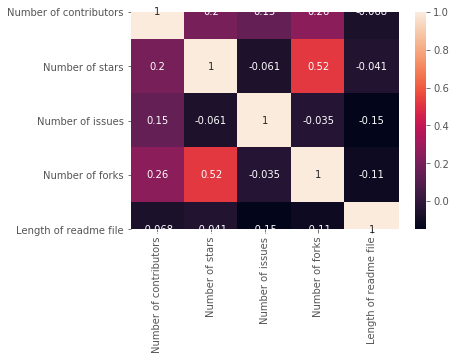

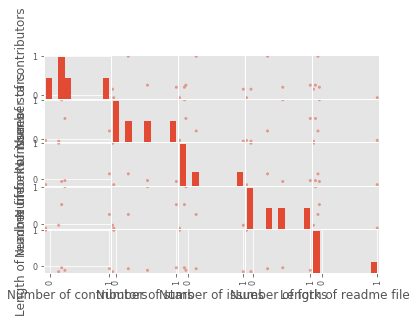

In [7]:
#PREMISSION ONLY
import seaborn as sns#lib for heat map

rep_describe=rep_dataf.describe()#first we will save the describetion to var
rep_corr_mat=rep_dataf.corr()#creating a correlation matrix
print(sns.heatmap(rep_corr_mat,annot=True))#visualize to heatmap


from pandas.plotting import scatter_matrix
scat_mat=scatter_matrix(rep_corr_mat)#visualize correlation matrix with scatterplot matrix
print(scat_mat)
